<a href="https://colab.research.google.com/github/hedzer8/BERT/blob/main/BERT_STATAPP_NYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Project_classification_Article/

/content/drive/My Drive/Project_classification_Article


In [ ]:
!pip install pandas
!pip install transformers

In [ ]:
##importation des librairies  
import pandas as pd
import torch
from tqdm.notebook import tqdm
import random
import numpy as np
import json
import matplotlib.pyplot as plt


## librairies de torch pour le traitement et la préparation de data pour le training.
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


## Librairies Algorithme de BERT. 
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

## Metrics f1 score pour validation.
from sklearn.metrics import f1_score, roc_curve, recall_score

## Pour spliter la data.
from sklearn.model_selection import train_test_split


# ***BERT PYTORCH ***:


### Processing de la Data pour la première méthode:

In [ ]:
## Lecture des données à partir des json Files
df1  = pd.read_json('file(3).json', lines=True)
df2  = pd.read_json('file(4).json', lines=True)
df3  = pd.read_json('file(9).json', lines=True)

## Elimination de quelques colonnes
del df1['meta']
del df1['annotation_approver']

del df2['meta']
del df2['annotation_approver']

del df3['meta']
del df3['annotation_approver']

# On va concatener les 3 DataFrame
df = df1
df.iloc[:,2] = df.iloc[:,2] + df2.iloc[:,2] + df3.iloc[:,2]

Le code suivant permet de récuperer les phrases correspondante à chaque label.

In [ ]:
df_extracted = pd.DataFrame(columns = ['text','label'])
for i in range(df.shape[0]):
  annot_i = df.iloc[i,2]
  text_i = df.iloc[i,1]
  for j in range(len(annot_i)):
    if annot_i[j]['label'] == 449 and annot_i[j]['user'] == 53 : 
      # l.append(annot_i[j])
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'endo'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 450 and annot_i[j]['user'] == 53 : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'exo'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 452 and annot_i[j]['user'] == 51  : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'hr'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 454 and annot_i[j]['user'] == 51  : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']), ignore_index=True)
  
  l=[]
  for j in range(len(annot_i)):
    if annot_i[j]['user'] == 53 or annot_i[j]['user'] == 51:
      l.append((annot_i[j]['start_offset'],annot_i[j]['end_offset']))
  
  taille_text = len(text_i)
  l_sorted = sorted(l, key=lambda x: x[0])
  if len(l_sorted)!=0:
    ind_deb = 0
    ind_fin = l_sorted[0][0]
    l = []
    l.append((ind_deb, ind_fin))
    for i in range(len(l_sorted)-1):
      current_tuple = l_sorted[i]
      tup = l_sorted[i+1]
      if current_tuple[1] != tup[0]:
        ind_deb = current_tuple[1]
        ind_fin = tup[0]
        if (ind_fin-ind_deb) >10 :
          l.append((ind_deb, ind_fin))
          df_extracted = df_extracted.append(pd.Series([text_i[ind_deb: ind_fin],'ne'], index=['text','label']), ignore_index=True)
      if i+1 == len(l_sorted)-1 :
        l.append((ind_deb, taille_text))
      df_extracted = df_extracted.append(pd.Series([text_i[ind_deb: taille_text],'ne'], index=['text','label']), ignore_index=True)
df_extracted.drop_duplicates(keep = 'first', inplace=True)
df_1 = df_extracted.reset_index(drop='True')



In [ ]:
# La répartition des label dans notre dataset
df_1.value_counts('label')

label
ne       537
exo      298
endo     119
perso     76
hr        49
dtype: int64

La celule suivante fait le traitement pour les données extras

In [ ]:
df4 = pd.read_json('extra_hr.json', lines=True)
df5 = pd.read_json('extra_perso.json', lines=True)
df6 = pd.read_json('extra_ee.json', lines=True)

del df4['meta']
del df4['annotation_approver']

del df5['meta']
del df5['annotation_approver']

del df6['meta']
del df6['annotation_approver']

df = df4
df.iloc[:,2] = df.iloc[:,2] + df5.iloc[:,2] + df6.iloc[:,2]


df_extracted = pd.DataFrame(columns = ['text','label'])
for i in range(df.shape[0]):
  annot_i = df.iloc[i,2]
  text_i = df.iloc[i,1]
  for j in range(len(annot_i)):
    if annot_i[j]['label'] == 573  : 
      # l.append(annot_i[j])
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'endo'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 574  : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'exo'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 575   : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'hr'], index=['text','label']), ignore_index=True)
    elif annot_i[j]['label'] == 576   : 
      # print(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']))
      df_extracted = df_extracted.append(pd.Series([text_i[annot_i[j]['start_offset']:annot_i[j]['end_offset']],'perso'], index=['text','label']), ignore_index=True)
  
  l=[]
  for j in range(len(annot_i)):
      l.append((annot_i[j]['start_offset'],annot_i[j]['end_offset']))
  
  taille_text = len(text_i)
  l_sorted = sorted(l, key=lambda x: x[0])
  if len(l_sorted)!=0:
    ind_deb = 0
    ind_fin = l_sorted[0][0]
    l = []
    l.append((ind_deb, ind_fin))
    for i in range(len(l_sorted)-1):
      current_tuple = l_sorted[i]
      tup = l_sorted[i+1]
      if current_tuple[1] != tup[0]:
        ind_deb = current_tuple[1]
        ind_fin = tup[0]
        if (ind_fin-ind_deb) >10 :
          l.append((ind_deb, ind_fin))
          df_extracted = df_extracted.append(pd.Series([text_i[ind_deb: ind_fin],'ne'], index=['text','label']), ignore_index=True)
      if i+1 == len(l_sorted)-1 :
        l.append((ind_deb, taille_text))
      df_extracted = df_extracted.append(pd.Series([text_i[ind_deb: taille_text],'ne'], index=['text','label']), ignore_index=True)
df_extracted.drop_duplicates(keep = 'first', inplace=True)
df_2 = df_extracted.reset_index(drop='True')

In [ ]:
df_2.value_counts('label')

label
ne      225
exo     142
endo     64
hr       37
dtype: int64

On va concatener les données de bases avec les données extras.

In [ ]:
df  = pd.concat([df_1,df_2], ignore_index=True).reset_index(drop='True')

Le nombre de passages pour chaque label est donnée par le tableau ci-dessous.

In [ ]:
df.value_counts('label')

label
ne       762
exo      440
endo     183
hr        86
perso     76
dtype: int64

Après traitement de la data, on va entamer la partie de encodage des labels

In [ ]:
## Encodage de label
df=df.rename(columns={"label": "type",})
## Enumeration des labels
possible_labels = df.type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print('Le dictionnaire qui représente type de label et le label correspondent pour l entrainement: \n', label_dict)

Le dictionnaire qui représente type de label et le label correspondent pour l entrainement: 
 {'hr': 0, 'perso': 1, 'exo': 2, 'endo': 3, 'ne': 4}


In [ ]:
df['label'] = df.type.replace(label_dict)

In [ ]:
df.head()

,text,type,label
0,choosing the Republican nominee to run against...,hr,0
1,the Republican dropped out and endorsed the De...,hr,0
2,Conservatives took the Republican retreat as a...,hr,0
3,Even if you've got a slight majority,hr,0
4,"Ms. Przybylski, who describes herself as ''jus...",perso,1


Préparation de la donnée pour l'entrainement, on va appliquer un splitting stratifié à l'aide de *train_test_split* de Sklearn. Le set de validation contiendra 20% de la dataset.


In [ ]:
## splitting data to train and test 
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
## On va ajouter une colonne pour différencier entre le Data de training et celui de validation
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['type', 'label', 'data_type']).count()

text
type  label data_type      
endo  3     train       146
            val          37
exo   2     train       352
            val          88
hr    0     train        69
            val          17
ne    4     train       609
            val         153
perso 1     train        61
            val          15

### BertTokenizer et encodage des textes :
La tokenisation est un processus permettant de prendre des textes bruts et de les diviser en jetons, qui sont des données numériques pour représenter des mots. 

In [ ]:
## importation du tokenizer à partir du modèle de BERT pré-entraîné.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
## codage des données de training
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)
## codage des données de test
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

## Récupération des données codées pour le training
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## Mettre les données de training et de validation sous forme de Tensor pour l'entrainement de Pytorch 
## car Pytorch n'accepte que les tensors
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Importation du model pré-entaîné de Bert.

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
## paramètres d'entrainement pour le réseau BERT
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
## set des paramètres de calculs
batch_size = 4 # groupe de 4 PAR 4 POUR L'algo
epochs = 10 #12 itération choix à la main sinon risque over fittting
## utilisation du générateur de pytorch pour entraîner les données. organiser la data a l'entrée de l'algo
## le but du générateur est de combiner un ensemble de données et un échantillonneur (échantilloner les données), et fournir une itération sur l'ensemble de données donné
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
### Définition de l'optimizer (algo d'optimisation qui servent à optimiser les poids de neurones)
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Training du modèle :

Définition des metriques pour la validation et l'entraînement du modèle.

In [ ]:
## définition de l'accuracy et le f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted') #précision de l'algorithme

def AverageRecall(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='weighted') #average acuracy recall 

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
# definiton de l'accuracy pour chaque label
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

On va définir dans ce qui suit une fonction *evaluate*  qui permet de renvoyer l'erreur par rapport au set de validation, ainsi que les labels prédit et les vraiss labels. Plus précisément, fonction qui évalue l'évolution de l'erreur, et qui renvoit les labels prédits par l'algorithme. Est ce qu'il apprend bien. Pour le

In [ ]:
## Définition de la fonction evaluate qui permet de evaluer le modèle sur le test de validation 

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
## Set du device pour la compilation (le modèle pré-entraîné utilise un réseau de neuronnes à plus de 120M de paramètres, il nécisste donc un gpu ici cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


La cellule qui suit permet de lancer le training


In [ ]:
Loss_train_list=[] ## liste pour l'erreur d'entaînement 
F1_score_list =[] ## Liste contant le F1_score sur le set de validation au courant des epochs
Recall_accuracy_list = []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_methode1_epoch_{epoch}.model')
     #enrigistrer le modèle à chaque epoch, on sauvegarde le modèle à chaque epochs   
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)  
    Loss_train_list.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    F1_score_list.append(val_f1)

    val_recall = AverageRecall(predictions, true_vals)
    Recall_accuracy_list.append(val_recall)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Recall Score (Weighted): {val_recall}')


Epoch 1
Training loss: 0.9670107356603107
Validation loss: 0.7285996555613402
F1 Score (Weighted): 0.658018081270444
Recall Score (Weighted): 0.7161290322580646



Epoch 2
Training loss: 0.6477230592300335
Validation loss: 0.6791290616473327
F1 Score (Weighted): 0.7028514487376876
Recall Score (Weighted): 0.7516129032258064



Epoch 3
Training loss: 0.5099123816651803
Validation loss: 0.6452454264598111
F1 Score (Weighted): 0.7148073158157363
Recall Score (Weighted): 0.7548387096774194



Epoch 4
Training loss: 0.3458003387891597
Validation loss: 0.7451132599425574
F1 Score (Weighted): 0.7348718375073546
Recall Score (Weighted): 0.7580645161290323



Epoch 5
Training loss: 0.2258747384305142
Validation loss: 0.7740343765472062
F1 Score (Weighted): 0.7499661499694704
Recall Score (Weighted): 0.7483870967741936



Epoch 6
Training loss: 0.13330450706491848
Validation loss: 0.9724178001230869
F1 Score (Weighted): 0.7622974827764655
Recall Score (Weighted): 0.7645161290322581



Epoch 7
Training loss: 0.09239193194493231
Validation loss: 1.0867878316509096
F1 Score (Weighted): 0.7621676122116517
Recall Score (Weighted): 0.7645161290322581



Epoch 8
Training loss: 0.06625190742328883
Validation loss: 1.1564137938212997
F1 Score (Weighted): 0.7576625922147477
Recall Score (Weighted): 0.7548387096774194



Epoch 9
Training loss: 0.042610928877782554
Validation loss: 1.1937037706449747
F1 Score (Weighted): 0.7552898773361817
Recall Score (Weighted): 0.7548387096774194



Epoch 10
Training loss: 0.03413380142057224
Validation loss: 1.2088275310077454
F1 Score (Weighted): 0.7552898773361817
Recall Score (Weighted): 0.7548387096774194



## Chargement du modèle entraîné pour la validation:

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

On va plotter l'évolution de la F1-Score au courant des epochs.

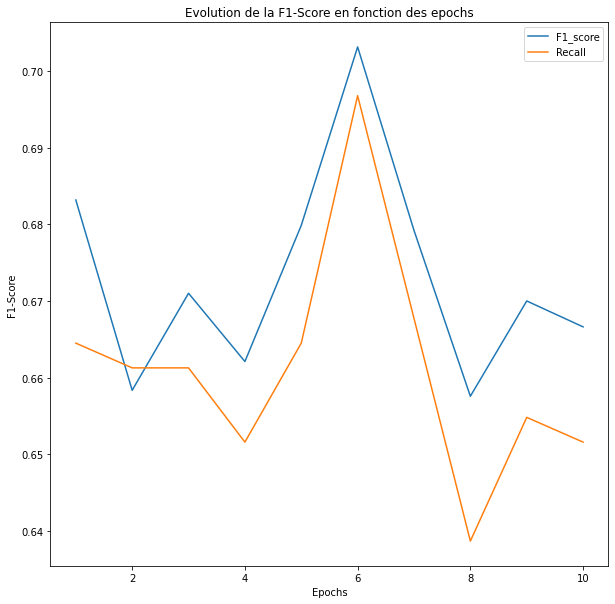

In [ ]:
fig = plt.figure(figsize=(10,10))
X = np.arange(1, epochs+1)
plt.plot(X, F1_score_list, label = 'F1_score')
plt.plot(X, Recall_accuracy_list , label = 'Recall')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.title('Evolution de la F1-Score en fonction des epochs')
fig.show()

#l'algo prend en compétence durant l'apprentissage


On va traçer l'evolution de l'accuracy de chaque classe en fonction des epochs.

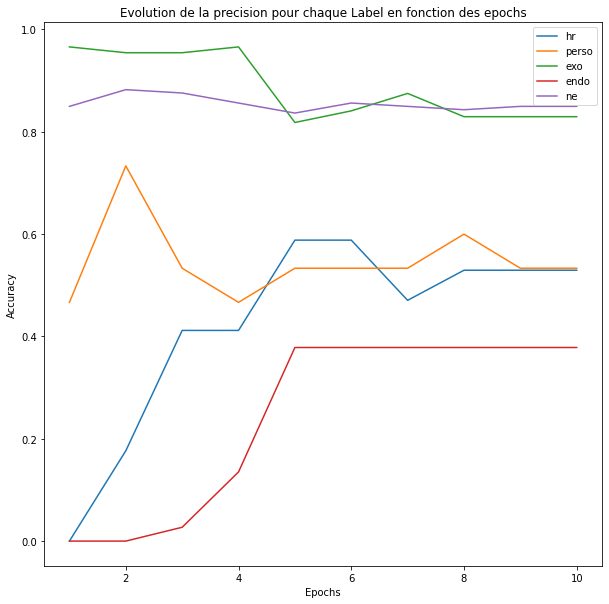

In [ ]:
Accuracy_by_step = {}
for i in range(epochs):
  model.load_state_dict(torch.load('finetuned_BERT_methode1_epoch_'+str(i+1)+'.model', map_location=torch.device('cpu')))   
  _, preds, true_vals = evaluate(dataloader_validation) 
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = true_vals.flatten()

  for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat==label]
      y_true = labels_flat[labels_flat==label]
      if i == 0:
        Accuracy_by_step[label]=[]
      Accuracy_by_step[label].append(len(y_preds[y_preds==label])/len(y_true))
    

fig = plt.figure(figsize=(10,10))
X = np.arange(1,epochs+1)
for key in label_dict.keys():
  plt.plot(X,Accuracy_by_step[label_dict[key]], label= key)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution de la precision pour chaque Label en fonction des epochs')
plt.legend()
fig.show()

Dans la cellule qui suit on va traçer la courbe ROC qui représente le taux des vrais positives en fonction des faux positives.

In [ ]:
model.load_state_dict(torch.load('finetuned_BERT_methode1_epoch_6.model', map_location=torch.device('cpu')))   
_, preds, true_vals = evaluate(dataloader_validation) 
preds_flat = np.argmax(preds, axis=1).flatten()
labels_flat = true_vals.flatten()

On calculera la matrice de confusion, elle permet  de mesurer la qualité d'un système de classification. Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée.

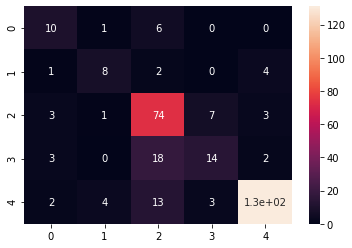

In [ ]:
##  matrice de confusion 
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(labels_flat, preds_flat), annot=True)
 

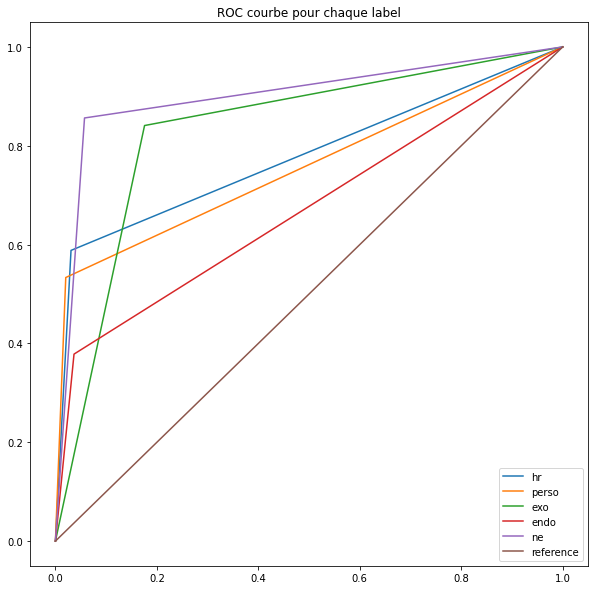

In [ ]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_flat, preds_flat==i, pos_label=i)
    
fig = plt.figure(figsize=(10, 10))
for key in label_dict.keys():
  plt.plot(fpr[label_dict[key]],tpr[label_dict[key]], label = key)
plt.plot([0,1],[0,1], label = 'reference')
plt.legend()
plt.title('ROC courbe pour chaque label')
plt.show()

La courbe ROC permet de déduire que notre modèle marche bien on est au dessus de la courbe de référence.

Dans la cellule suivante on présentera les résultats d'accuracy selon chaque chaque classe pour le modèle qui a le plus grand F1-score.

In [ ]:
accuracy_per_class(preds, true_vals)

Class: hr
Accuracy: 10/17

Class: perso
Accuracy: 8/15

Class: exo
Accuracy: 74/88

Class: endo
Accuracy: 14/37

Class: ne
Accuracy: 131/153



# Application sur le reste des Articles :


Dans cette partie, on va utiliser la première méthode pour prédire les classes des articles à labelliser. Pour cela on va récupérer notre modèle entraîné de la première méthode ensuite; on va l'utiliser pour classer ces articles selon ces clusters.


In [ ]:
# importation des librairies nécessaires pour l'acquisition et le traitement des Articles
import os
import re
import pandas as pd

from lxml import etree
from datetime import datetime
from glob import glob

from time import time

In [ ]:
#Fonctions intermédiaires de traitement
def get_section():
    xsection = tree.xpath(path +'//td/b[text()="SE"]/following::node()[2]/text()')
    section = ''
    for ele in xsection: #on prévoit le cas où xsection contient plusieurs éléments
        ele = re.sub('\n','',ele) #on enlève les caractères indésirables
        if ele and re.search('.*Desk',str(ele)):
            ele=re.search('.*Desk',str(ele)).group() #on récupère la section (format : "~ Desk; Section ~")
            section += ele
    return section

def get_title():
    xtitle = tree.xpath(path +'//td/span[@class = "enHeadline"]//text()')
    title = ''
    for ele in xtitle:
        ele = re.sub('\n','',ele)
        if ele :
            title += ele
    return title

def get_author():
    xauthor = tree.xpath(path+ '//td/b[text()="BY"]/following::node()[2]/text()')
    author = ''
    for ele in xauthor:
        if ele and re.search('\w{3,}.*',ele):
            ele = re.search('\w{3,}.*',ele).group() #le format trouvé dans xauthor : 'By Prénom Nom' ; \w{3,} capture les deux derniers mots
            author += ele
    return author

def get_wc():
    x_wc = tree.xpath(path + '//td/b[text()="WC"]/following::node()[2]/text()')
    wc = ''
    for ele in x_wc:
        ele = re.sub(' mots','',ele)
        wc += ele
    return wc

def get_date():
    xdate = tree.xpath(path + '//td/b[text()="PD"]/following::node()[2]/text()') 
    date = date_to_eng(xdate[0]) #conversion de la date en anglais
    date = datetime.strptime(date, '%d%b%Y').date() #conversion en format datetime
    return date

def get_text():
    xtext = tree.xpath(path + '//td/p/b[text()="CX" or "LP" or "TD"]/following::td[1]//text()')
    text = ''
    for ele in xtext:
        pattern = re.compile('\n|\xa0')
        ele = re.sub(pattern,' ',ele)
        if ele:
            text += ele
    return text

#Fonction de traduction de la date en anglais
def date_to_eng(str):
    date=re.split(' ',str)
    month = date[1]
    d_year = {'janvier':'Jan','février':'Feb',
              'mars':'Mar','avril':'Apr','mai':'May',
              'juin':'Jun','juillet':'Jul','août':'Aug',
              'septembre':'Sep','octobre':'Oct','novembre':'Nov','décembre':'Dec'}
    month = d_year.get(month)
    n_date = date[0] + month + date[2] #on rétablit le format JJMMYYYY
    return n_date

In [ ]:
archives=glob('factiva*/*.html') #on obtient les paths de chaque fichier

In [ ]:
start= time()
#Importation du parser
htmlparser = etree.HTMLParser()

#Récupération de la base de données

#On commence par appliquer le traitement sur le 1er fichier
with open(archives[0],encoding='utf-8') as f:
    tree = etree.parse(f,htmlparser)

#récupération de l'identifiant de chaque article
id_article = tree.xpath('//div[starts-with(@id,"article")]/@id')

#à l'aide de fonctions intermédiaires, on récupère pour chaque article la section, le titre, l'auteur, le nombre de mots, la date, le texte
d_article = {}

for i in id_article :
    article = str(i)
    path='//div[@id = "%s"]' % article
    article=re.sub('article-','',article) #on ne garde que l'identifiant
    d_article[article]=[get_section(),get_title(),get_author(),get_wc(),get_date(),get_text()]

df= pd.DataFrame(data = d_article.values(),index=d_article.keys(),columns=['Section','Title','Author','Word Count','Date','Article'])
df=df.rename_axis('Identification Number').reset_index()


#On applique le traitement sur tous les autres
for archive in archives[1:]:
    #construction de l'arbre
    with open(archive,encoding='utf-8') as f:
        tree = etree.parse(f, htmlparser)
    
    #récupération de l'identifiant de chaque article
    id_article = tree.xpath('//div[starts-with(@id,"article")]/@id')
    
    #à l'aide de fonctions intermédiaires, on récupère pour chaque article la section, le titre, l'auteur, le nombre de mots, la date, le texte
    d_article = {} #on les stockera dans un dictionnaire
    
    for i in id_article :
        article = str(i)
        path='//div[@id = "%s"]' % article
        article=re.sub('article-','',article) #on ne garde que l'identifiant
        d_article[article]=[get_section(),get_title(),get_author(),get_wc(),get_date(),get_text()]

    #Construction d'un DataFrame
    df1=pd.DataFrame(data = d_article.values(),index=d_article.keys(),columns=['Section','Title','Author','Word Count','Date','Article'])
    df1=df1.rename_axis('Identification Number').reset_index()
    df=df.append(df1,ignore_index=True) #on ajoute les données obtenues aux données précédentes

end = time()
df.head()

,Identification Number,Section,Title,Author,Word Count,Date,Article
0,NYTF000020110101e7110002m,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,218,2011-01-01,"JUNEAU, Alaska (AP) -- Joe Miller, a Tea Party..."
1,NYTF000020110101e7110002y,Foreign Desk,"IN IVORY COAST, BID TO EASE OUT DEFIANT LEADER",ERIC LIPTON and SHERYL GAY STOLBERG; Eric Lip...,1023,2011-01-01,WASHINGTON -- President Laurent Gbagbo vowed F...
2,NYTF000020110101e71100030,National Desk,"In California, What's Old Is New Again",JENNIFER MEDINA,628,2011-01-01,SACRAMENTO -- Just days before Governor-elect ...
3,NYTF000020110101e71100031,National Desk,"Wisconsin State Workers Fret, as G.O.P. Takes ...",MONICA DAVEY,752,2011-01-01,"MADISON, Wis. -- In preparation for Monday's i..."
4,NYTF000020110101e71100032,National Desk,2011: The Year of Political Change,,211,2011-01-01,JAN. 1 is technically no different from any ot...


Pour notre étude on va se focaliser sur un DataFrame avec 5 colonnes: 

*   Section : La section à laquelle appartient l'article
*   Title : Le titre de l'article
*   Author : l'auteur de l'article
*   Date :  la date de publication de l'article
*   Article : correspond à l'article







In [ ]:
# Data frame qu'on va utiliser pour la prédiction
df_topredict = pd.DataFrame(df[['Section', 'Title', 'Author', 'Date', 'Article']])
df_topredict.shape

(9700, 5)

### Partie Segmentation des Articles :
Dans cette partie on va segmenter les textes en plusieurs phrases, ensuite on va faire les prédictions sur ces phrases et voir la distribution de chaque classe pour un Article donnée.


In [ ]:
## importation de librairies pour spleeter les articles en plusieurs phrases
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

On va spleeter les articles en plusieurs phrases, chaque Artcile est repéré à l'aide de son Titre, Date de publication, Author et Section.



In [ ]:
## Créer un Data Frame pour les Articles spleeter 
df_text_splitted = pd.DataFrame(columns = ['Section', 'Title', 'Author', 'Date', 'phrase', 'label']) 

## Paramètres pour récupérer N articles pour l'étude statistique
# N = df_topredict.shape[0] # Pour tout les Articles
N = 30
## Boucle pour spleeter Article par Article
for i in range(N):
  token_text = sent_tokenize(df_topredict['Article'].iloc[i])
  for j in range(len(token_text)):
    df_text_splitted = df_text_splitted.append(pd.Series([df_topredict['Section'].iloc[i], df_topredict['Title'].iloc[i], df_topredict['Author'].iloc[i], df_topredict['Date'].iloc[i], token_text[j],0], index=['Section', 'Title', 'Author', 'Date', 'phrase', 'label']), ignore_index=True)
df_text_splitted.head()

,Section,Title,Author,Date,phrase,label
0,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"JUNEAU, Alaska (AP) -- Joe Miller, a Tea Party...",0
1,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,The decision came one day after the state cert...,0
2,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,TD Mr. Miller had the option of appealing a fe...,0
3,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"Saying he had to accept ''practical realities,...",0
4,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"Three courts ruled against Mr. Miller, who arg...",0


In [ ]:
## importation du tokenizer à partir du modèle de BERT pré-entraîné.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
## codage des données 
encoded_data_train = tokenizer.batch_encode_plus(
    df_text_splitted.phrase.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

## Récupération des données de coder pour le test
input_ids = encoded_data_train['input_ids']
attention_masks = encoded_data_train['attention_mask']
labels =torch.tensor(list(df_text_splitted.label.values))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
## Mettre les données sous forme de tensor
tensor_set = TensorDataset(input_ids, attention_masks, labels)


In [ ]:
## Generer un generateur de données pour les données à predire
batch_size = 4
dataloader = DataLoader(tensor_set, sampler=SequentialSampler(tensor_set), batch_size=batch_size)

In [ ]:
## Set du device pour la compilation (le modèle pré-entraîné utilise un réseau de neuronnes à plus de 120M de paramètres)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Télecharger le meilleur modèle pour les prédiction.

In [ ]:
model.load_state_dict(torch.load('finetuned_BERT_methode1_epoch_6.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# prediction des classes en utilisant la fonction evaluate
_, pred_label, _ = evaluate(dataloader)

# Traitement des labels
pred_label = np.argmax(pred_label, axis=1).flatten()

Ajouter les labels prédit dans le DataFrame des testes spleeter.

In [ ]:
possible_labels

array(['hr', 'perso', 'exo', 'endo', 'ne'], dtype=object)

In [ ]:
df_text_splitted["label"] = pred_label
label_dict_1 = {}
possible_labels = ['hr', 'perso', 'exo', 'endo', 'ne']
for index, possible_label in enumerate(possible_labels):
    label_dict_1[index] = possible_label

df_text_splitted["type"] = df_text_splitted.label.replace(label_dict_1)
df_text_splitted.head()

,Section,Title,Author,Date,phrase,label,type
0,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"JUNEAU, Alaska (AP) -- Joe Miller, a Tea Party...",2,exo
1,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,The decision came one day after the state cert...,2,exo
2,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,TD Mr. Miller had the option of appealing a fe...,2,exo
3,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"Saying he had to accept ''practical realities,...",2,exo
4,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,"Three courts ruled against Mr. Miller, who arg...",2,exo


### Présentation des résultats sur les Articles avec une étude statistique sur la répartition des clusters : 
Pour cette étude statistiques on va prendre que 400 articles, le but est de présenter la méthodologie de traitement et de prsenter les résultats de notre modèle de classification BERT.


Dans ce qui suit on va commencer par calculer le pourcentage de chaque cluster pour chaque Article.


In [ ]:
# Calculer Le pourcentage de chaque cluster pour chaque text
df_text_result = df_text_splitted.groupby(['Section', 'Title', 'Author', 'Date']).groups
label_percent_by_class = [] # une liste qui va contenir le pourcentage pour chaque label
for key in df_text_result.keys():
  group = df_text_splitted.loc[list(df_text_result[key])[:],:].groupby(['label']).groups
  keys = group.keys()
  L = [0 for i in range(4)]
  for key in keys:
    if key != 4:
      L[key] = len(group[key])
  L_percent = [L[i]/sum(L) for i in range(len(L))]
  
  label_percent_by_class.append(L_percent)
  

On va créer un DataFrame qui va contenir pour chaque Article le pourcentage de chaque cluster. Le DataFrame est caractérisé par 8 colonnes : 


*   Section : La section à laquelle appartient l'Article.
*   Title : Le titre de l'Article.
*   Author : l'auteur de l'article.
*   Date : Date de publication de l'Article.
*   Pourcentage_hr : pourcentage du label 'hr' dans le texte donnée.
*   Pourcentage_perso : pourcentage du label 'perso' dans le texte donnée.
*   Pourcentage_exo : pourcentage du label 'exo' dans le texte donnée.
*   Pourcentage_endo : pourcentage du label 'endo
' dans le texte donnée.



In [ ]:
# DataFrame qui contient la répartition de chaque label par Article
df_class_percent_by_Article = pd.DataFrame(columns = ['Section', 'Title', 'Author', 'Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']) 
for i in range(len(label_percent_by_class)) : 
  elt = label_percent_by_class[i]
  df_class_percent_by_Article = df_class_percent_by_Article.append(pd.Series([df_topredict['Section'].iloc[i], df_topredict['Title'].iloc[i], df_topredict['Author'].iloc[i], df_topredict['Date'].iloc[i], elt[0], elt[1], elt[2], elt[3]], index=['Section', 'Title', 'Author', 'Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']), ignore_index=True)

df_class_percent_by_Article.head()

,Section,Title,Author,Date,pourcentage_hr,poucentage_perso,poucentage_exo,poucentage_endo
0,National Desk,Miller Ends Fight in Alaska Election,ASSOCIATED PRESS,2011-01-01,0.123711,0.030928,0.845361,0.000000
1,Foreign Desk,"IN IVORY COAST, BID TO EASE OUT DEFIANT LEADER",ERIC LIPTON and SHERYL GAY STOLBERG; Eric Lip...,2011-01-01,0.000000,0.017544,0.596491,0.385965
2,National Desk,"In California, What's Old Is New Again",JENNIFER MEDINA,2011-01-01,0.000000,0.000000,0.947368,0.052632
3,National Desk,"Wisconsin State Workers Fret, as G.O.P. Takes ...",MONICA DAVEY,2011-01-01,0.000000,0.060606,0.909091,0.030303
4,National Desk,2011: The Year of Political Change,,2011-01-01,0.000000,0.000000,0.965517,0.034483


L'etude suivante permet de chercher la répartition des labels au cours du temps suivant la date de publication des Articles. Ensuite on va représenter cette évolution dans graphes bar.

In [ ]:
df_class_percent_by_Article[['Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']].groupby('Date').mean()

,pourcentage_hr,poucentage_perso,poucentage_exo,poucentage_endo
Date,,,,
2011-01-01,0.020619,0.018180,0.877305,0.083897
2011-01-02,0.052881,0.008191,0.719660,0.219267
2011-01-03,0.102579,0.018056,0.686270,0.193095
2011-01-04,0.107727,0.061364,0.781515,0.049394


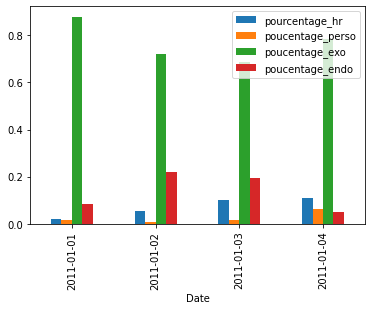

In [ ]:
df_class_percent_by_Article[['Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']].groupby('Date').mean().plot.bar()

On va calcuer l'evolution des cluster selon chaque Section et par ordre chronologique. Ensuite on va faire un représentation graphique pour illustrer l'evolution.


In [ ]:
df_class_percent_by_Article[['Section', 'Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']].groupby(['Section','Date']).mean()

pourcentage_hr  ...  poucentage_endo
Section                 Date                        ...                 
                        2011-01-02        0.066667  ...         0.266667
Business/Financial Desk 2011-01-03        0.000000  ...         0.360000
Editorial Desk          2011-01-02        0.000000  ...         0.000000
                        2011-01-03        0.191071  ...         0.055952
                        2011-01-04        0.375000  ...         0.000000
Foreign Desk            2011-01-01        0.000000  ...         0.385965
Magazine Desk           2011-01-02        0.000000  ...         0.266667
Metropolitan Desk       2011-01-03        0.100000  ...         0.400000
                        2011-01-04        0.090909  ...         0.000000
National Desk           2011-01-01        0.024742  ...         0.023483
                        2011-01-02        0.062079  ...         0.231714
                        2011-01-03        0.066667  ...         0.143333
                        2011-01-04        0.024242  ...         0.082323

[13 rows x 4 columns]

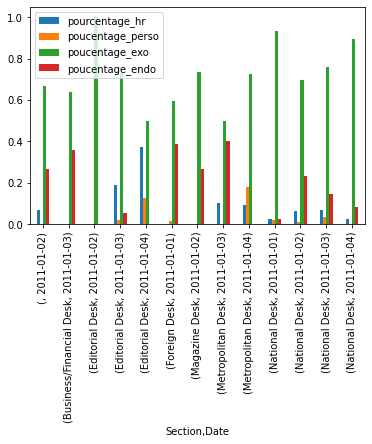

In [ ]:
# Pour le graphique on va choisir que 40 Articles pour la qualité de la visualisation
df_class_percent_by_Article[['Section', 'Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']][0:40].groupby(['Section', 'Date']).mean().plot.bar()

On va calcuer l'evolution des cluster pour chaque auteur. Ensuite on va faire un représentation graphique pour illustrer l'evolution.


In [ ]:
df_class_percent_by_Article[['Author', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']].groupby('Author').mean()

,pourcentage_hr,poucentage_perso,poucentage_exo,poucentage_endo
Author,,,,
,0.082944,0.036364,0.614748,0.265944
ADAM NAGOURNEY,0.072727,0.000000,0.763636,0.163636
ASHLEY PARKER,0.125000,0.041667,0.791667,0.041667
ASSOCIATED PRESS,0.123711,0.030928,0.845361,0.000000
CARL HULSE,0.000000,0.000000,0.916667,0.083333
DAN MIHALOPOULOS and DARNELL LITTLE; Mick Dumke contributed reporting.,0.000000,0.000000,0.571429,0.428571
DANNY HAKIM; Elizabeth Harris contributed reporting.,0.000000,0.000000,0.727273,0.272727
DIANE CARDWELL,0.100000,0.000000,0.500000,0.400000
"ERIC LIPTON and SHERYL GAY STOLBERG; Eric Lipton reported from Washington, and Sheryl Gay Stolberg from Honolulu. Adam Nossiter contributed reporting.",0.000000,0.017544,0.596491,0.385965


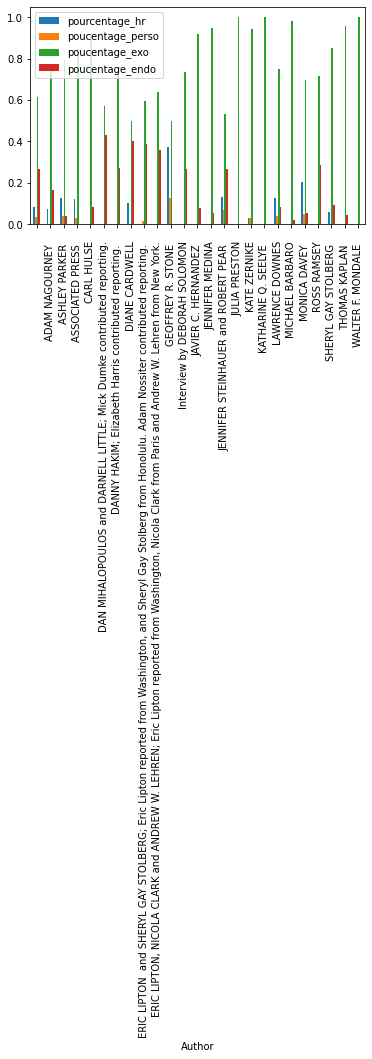

In [ ]:
df_class_percent_by_Article[['Author', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']][:40].groupby('Author').mean().plot.bar()

Evolution des cluster au courant du temps pour les 400 Articles.

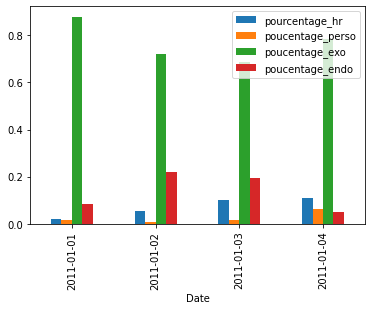

In [ ]:
df_class_percent_by_Article[['Date', 'pourcentage_hr', 'poucentage_perso', 'poucentage_exo', 'poucentage_endo']].groupby('Date').mean().plot.bar()